In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import plotly.express as px

In [2]:
# Load dataset 
df = pd.read_csv("games.csv")

In [3]:
# Selecting specific columns for the DataFrame
selected_columns = ['id', 'rated', 'winner', 'increment_code', 'white_rating', 'black_rating', 'moves', 'opening_name']
df = df[selected_columns].copy()  # Use .copy() to avoid SettingWithCopyWarning

# Simplify replacing values using map for better readability
df['result'] = df['winner'].map({"white": "White won", "black": "Black won", "draw": "Draw"})

# Convert True/False to 1/0 
df['rated'] = df['rated'].astype(int)

# Map 'winner' to numeric values
df['winner_dbl'] = df['winner'].map({'white': 1, 'black': 0, 'draw': 0.5})

# Calculate rating difference between white and black
df['rating_diff'] = df['white_rating'] - df['black_rating']

# Extracting base time from the increment code, handling NaN values appropriately
df['base_time'] = df['increment_code'].str.extract(r'^(\d+)')
df['base_time'] = df['base_time'].fillna(0).astype(int)  # Fill NaN with 0 then convert to int

# Filter out rows where base time is 0
df = df[df['base_time'] != 0]

# Determine if the game had increment
df['has_increment'] = (~df['increment_code'].str.contains(r'\+0')).astype(int)  # 0 if '+0' is in increment code, otherwise 1.

# Extract the first move from the moves column
df['first_move'] = df['moves'].str.extract(r'^(\S+)')

# Reset the index of the DataFrame after filtering and modifying
df.reset_index(drop=True, inplace=True)

# df.head()

In [4]:
def plot_bar_chart(df, x_column, y_column, color_column, labels, title, color_map, orientation, barmode):
    """
    Returns a customised plotly bar plot.
    """
    fig = px.bar(
        data_frame=df, 
        x=x_column, 
        y=y_column, 
        color=color_column, 
        labels=labels, 
        title=f"{title} <br><sup>(from 20,000 Lichess Games)</sup>", 
        template="plotly_white", 
        color_discrete_map=color_map, 
        orientation=orientation,
        barmode = barmode
    )
    fig.update_yaxes(showline=False,showgrid=False)
    fig.update_xaxes(showline=False,showgrid=False)
    return fig

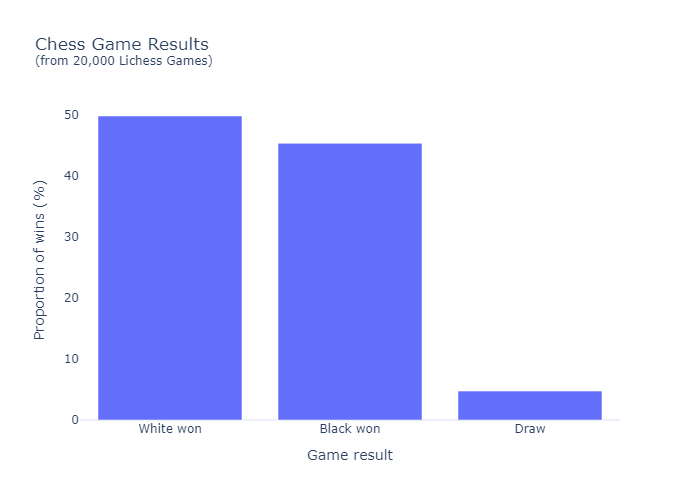

In [5]:
# Game results in percentage
game_result_df = df['result'].value_counts(normalize=True).reset_index()
game_result_df.columns = ['result', '%']
game_result_df['%'] = round(100 * game_result_df['%'], 2)

# Creating and showing the bar plot
game_result_bar = plot_bar_chart(game_result_df, 'result', '%', None, {"result": "Game result", "%": "Proportion of wins (%)"},
                            "Chess Game Results", None, None, None)

game_result_bar.show('png')

C:\Users\scsar\AppData\Local\Temp\ipykernel_12484\1688013056.py:34: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



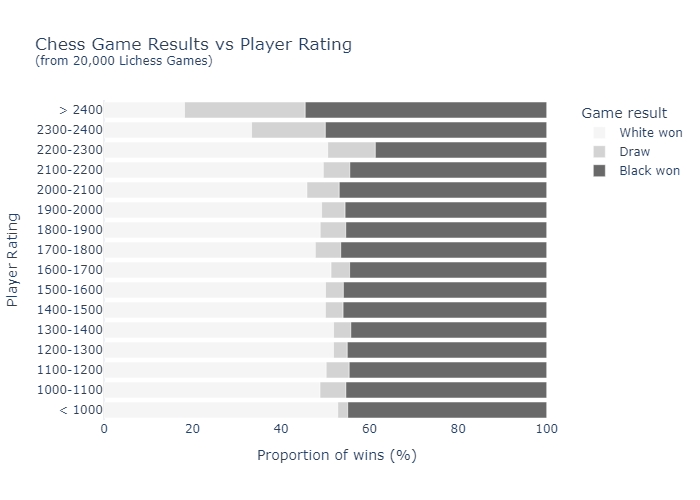

In [6]:
# Game results by average rating of players

# Calculating average rating
df['avg_rating'] = (df['white_rating'] + df['black_rating']) / 2

# Defining rating categories
rating_categories = [
    "< 1000",
    "1000-1100",
    "1100-1200",
    "1200-1300",
    "1300-1400",
    "1400-1500",
    "1500-1600",
    "1600-1700",
    "1700-1800",
    "1800-1900",
    "1900-2000",
    "2000-2100",
    "2100-2200",
    "2200-2300",
    "2300-2400",
    "> 2400"
]

# Creating average rating category
df['avg_rating_category'] = pd.cut(
    df['avg_rating'], 
    bins=[-np.inf, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, np.inf],
    labels=rating_categories
)

# Grouping and pivoting the data
rating_result_pivot = df.pivot_table(values='id', index='avg_rating_category', columns='result', aggfunc='count')

# Normalizing the data by row to get percentages
rating_result_percentage = rating_result_pivot.div(rating_result_pivot.sum(axis=1), axis=0) * 100

# Resetting the index for Plotly
rating_result_df = rating_result_percentage.reset_index()

# Melting the DataFrame for easier plotting
rating_df_melt = rating_result_df.melt(
    id_vars=['avg_rating_category'], 
    value_vars=['White won', 'Draw', 'Black won'],
    var_name='result',
    value_name='%'
)

# Function to create bar plot (assuming it's already defined)

# Creating and showing the bar plot
avg_rating_bar = plot_bar_chart(rating_df_melt, "%", "avg_rating_category", 'result', 
                                 labels={"avg_rating_category": "Player Rating", 
                                         "%": "Proportion of wins (%)", 
                                         "result": "Game result"}, 
                                 title="Chess Game Results vs Player Rating", 
                                 color_map={"White won": "whitesmoke", "Draw": "lightgrey", "Black won": "dimgrey"}, 
                                 orientation='h', barmode='relative'
                                )

avg_rating_bar.show('png')

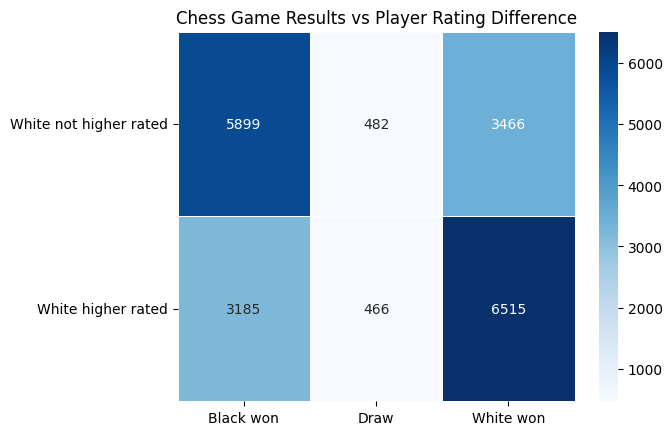

In [8]:
# Game results by rating difference 

# Determine whether the white player has a higher rating
df['white_is_higher'] = np.where(df['rating_diff'] > 0, 1, 0)

# Grouping and creating a pivot table
result_by_rating_diff = df.groupby(['white_is_higher', 'result']).size().reset_index(name='count')
pivot_result_by_rating_diff = pd.pivot_table(result_by_rating_diff, values='count', index='white_is_higher', columns='result')

# Creating a heatmap to visualize the results
rating_diff_hm = sns.heatmap(pivot_result_by_rating_diff, annot = True, cmap="Blues", linewidth=.5, fmt=".0f")
rating_diff_hm.set_title('Chess Game Results vs Player Rating Difference')
rating_diff_hm.set(xlabel = "", ylabel = "")
rating_diff_hm.set_yticklabels(labels = ["White not higher rated", "White higher rated"], rotation = 0)

plt.show()

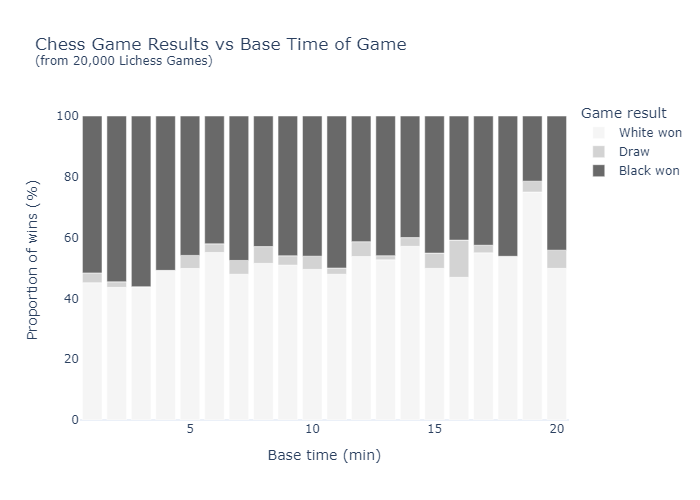

In [9]:
# Game results by game's base time

# Grouping and creating a DataFrame for game results by base time
base_time_results = df.groupby(['base_time', 'result']).size().reset_index(name='count')

# Filtering out games with base time more than 20 minutes
filtered_base_time_results = base_time_results[base_time_results.base_time <= 20]

pivot_filtered_base_time_results = pd.pivot_table(filtered_base_time_results, values='count', index='base_time', columns='result')
df_for_base_time_plot = pivot_filtered_base_time_results.reset_index().fillna(0)

melted_base_time_df = pd.melt(df_for_base_time_plot,
                              id_vars=['base_time'], 
                              value_vars=['White won', 'Draw', 'Black won'],
                              var_name='result',
                              value_name='count'
                             )
melted_base_time_df['Percentage'] = round(100 * melted_base_time_df['count'] / melted_base_time_df.groupby('base_time')['count'].transform('sum'), 2)

# Creating and showing the bar plot for game results vs base time
base_time_bar = plot_bar_chart(melted_base_time_df, "base_time", "Percentage", "result", 
                                labels={"base_time": "Base time (min)", 
                                        "Percentage": "Proportion of wins (%)", 
                                        "result": "Game result"}, 
                                title="Chess Game Results vs Base Time of Game", 
                                color_map={"White won": "whitesmoke", "Draw": "lightgrey", "Black won": "dimgrey"},
                                orientation='v', barmode="relative"
                               )
base_time_bar.show("png")

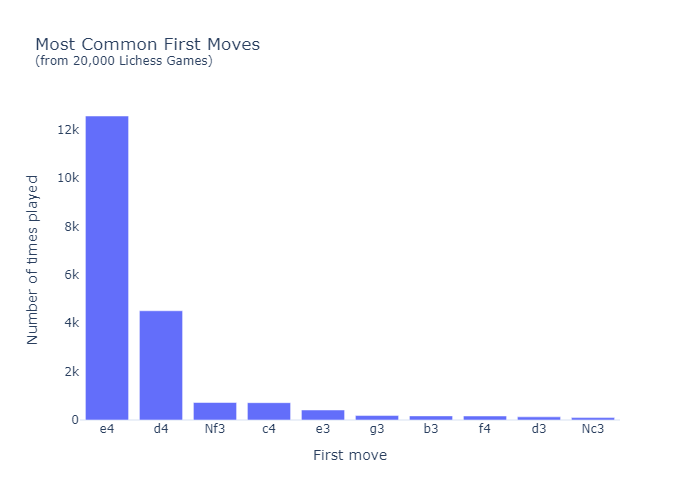

In [10]:
# Analysis of Opening Strategies
# - Which opening move is most common
# - Leads to the most wins
# - Do better players start with certain first moves/a sequence of first moves

first_move_df = df.groupby('first_move').size().reset_index(name='count')

# Sort the DataFrame by 'count' column in descending order and reset row index
first_move_df = first_move_df.sort_values(by='count', ascending=False)
first_move_df = first_move_df.reset_index(drop=True)

# Get the top 10 openings played
first_move_df = first_move_df.head(10)

first_move_bar = plot_bar_chart(first_move_df, 'first_move', 'count', 
                                 None, {"first_move": "First move", "count": "Number of times played"},
                                 "Most Common First Moves", None, None, None)
first_move_bar.show("png")

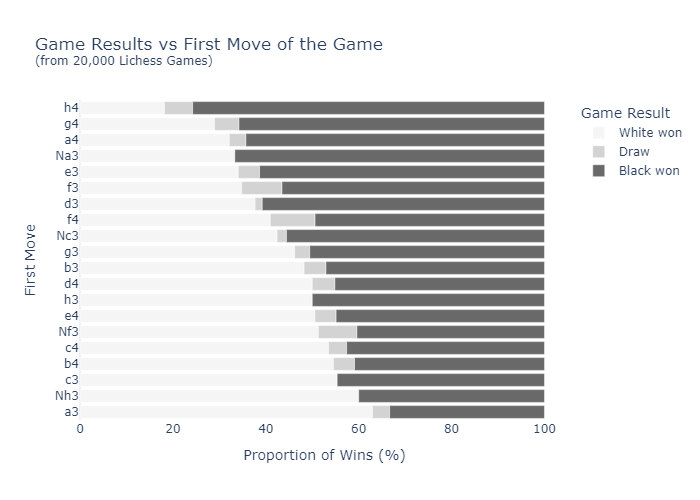

In [11]:
# Game results vs first move

# Grouping by first move and result, then counting occurrences
first_move_result_df = df.groupby(['first_move', 'result']).size().reset_index(name='count')

pivot_first_move_result = pd.pivot_table(first_move_result_df, values='count', index='first_move', columns='result')
pivot_first_move_result.reset_index(inplace=True)
pivot_first_move_result.sort_values(by='first_move', ascending=False, inplace=True)
pivot_first_move_result.fillna(0, inplace=True)

melted_first_move_df = pd.melt(pivot_first_move_result,
                               id_vars=['first_move'], 
                               value_vars=['White won', 'Draw', 'Black won'],
                               var_name='result',
                               value_name='count'
                              )
melted_first_move_df['Percentage'] = round(100 * melted_first_move_df['count'] / melted_first_move_df.groupby('first_move')['count'].transform('sum'), 2)

# Sorting by 'result' as 'White won' and then by 'Percentage' in descending order
melted_first_move_df.sort_values(by=['result', 'Percentage'], ascending=[False, False], inplace=True)

# Creating and showing the bar plot for game results vs first move
first_move_bar_plot = plot_bar_chart(melted_first_move_df, "Percentage", "first_move", 'result', 
                                      labels={"first_move": "First Move", "Percentage": "Proportion of Wins (%)", "result": "Game Result"}, 
                                      title="Game Results vs First Move of the Game", 
                                      color_map={"White won": "whitesmoke", "Draw": "lightgrey", "Black won": "dimgrey"}, 
                                      orientation='h', barmode="relative"
                                     )
first_move_bar_plot.update_yaxes(showline=False, showgrid=False)
first_move_bar_plot.update_xaxes(showline=False, showgrid=False)
first_move_bar_plot.show("png")

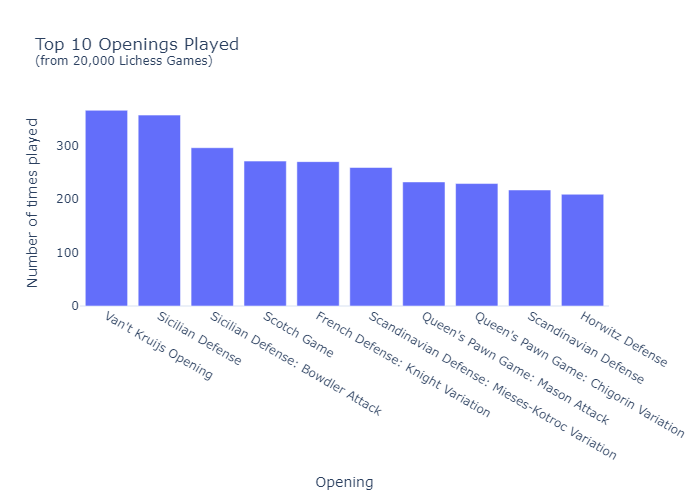

In [12]:
# Top 10 openings played

openings_df = df.groupby('opening_name').size().reset_index(name='count')

# Sort the DataFrame by 'count' column in descending order and reset row index
openings_df = openings_df.sort_values(by='count', ascending=False)
openings_df = openings_df.reset_index(drop=True)

openings_df = openings_df.head(10)

openings_bar = plot_bar_chart(openings_df, 'opening_name', 'count', None, 
                               {"opening_name": "Opening", "count": "Number of times played"},
                               "Top 10 Openings Played", None, None, None)
openings_bar.show("png")

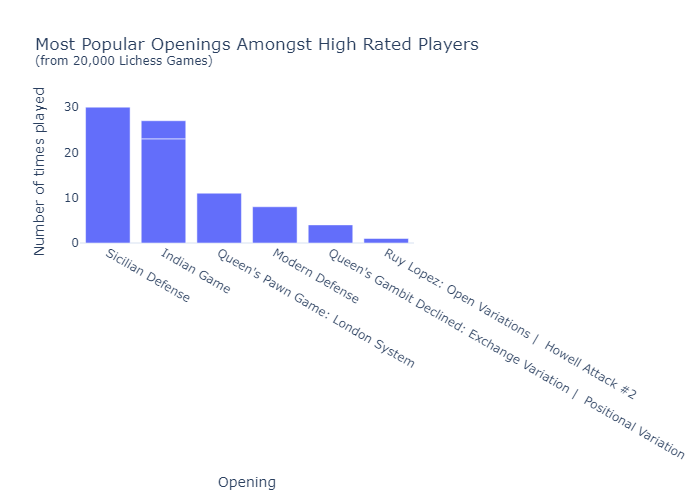

In [15]:
    # What are the most popular openings played by players with higher ratings?

# Initial filtering and sorting
higher_rated_openings_df = df.groupby(['opening_name', 'avg_rating_category'], observed=False).size().reset_index(name='count')
higher_rated_openings_df = higher_rated_openings_df[higher_rated_openings_df['count'] > 0]
higher_rated_openings_df = higher_rated_openings_df.sort_values(by='count', ascending=False)
higher_rated_openings_df = higher_rated_openings_df.reset_index(drop=True)

# Find the index of the row with the highest 'count' for each 'avg_rating_category'
idx = higher_rated_openings_df.groupby('avg_rating_category', observed=False)['count'].idxmax()

# Filter the DataFrame to keep only the rows with the highest 'count' for each 'avg_rating_category'
higher_rated_openings_df = higher_rated_openings_df.loc[idx].reset_index(drop=True)
higher_rated_openings_df = higher_rated_openings_df[higher_rated_openings_df['avg_rating_category'] > '1700-1800']

higher_rated_openings_bar = plot_bar_chart(higher_rated_openings_df, 'opening_name', 'count', None, 
                                            {"opening_name": "Opening", "count": "Number of times played"},
                                            "Most Popular Openings Amongst High Rated Players", None, None, None)
higher_rated_openings_bar.show("png")